# ***🔍 Recomendação de Produtos por Similaridade***

Este notebook implementa um sistema de recomendação de produtos baseado em similaridade de imagens. Ele é útil para e-commerces e lojas virtuais, permitindo sugerir produtos visualmente semelhantes aos que um usuário seleciona.


O processo envolve:

✅ **Baixar e preparar o dataset** (Fashion Product Images - Kaggle).

✅ **Treinar um modelo de Machine Learning** para extrair características visuais das imagens.

✅ **Criar um índice vetorial com Annoy** para busca eficiente por similaridade.

✅ Implementar um App Streamlit para teste e interação usando ngrock Tunnel para acesso externo.

✅ Implementar uma API Flask Cloudflare Tunnel para acesso externo.


## **📌 Etapa 1: Aquisição e Preparação dos Dados**

In [ ]:
# Monta o Google Drive para armazenar os arquivos do Kaggle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cria um arquivo kaggle.json para autenticação na API do Kaggle
%%writefile kaggle.json
{"username":"SEU-USUARIO","key":"SUA_API_KEY_KAGGLE"}

Writing kaggle.json


In [ ]:
# Instala e configura a biblioteca do Kaggle para baixar datasets
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=be05c8b9722af981688b1b04f0389f2be3e8e463991a4d7a811c84433fabc801
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


### Step 1: Data Acquisition

In [ ]:
# 📥 Baixa e extrai o dataset Fashion Product Images do Kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [ ]:
# 🗂 Organiza as imagens do dataset em categorias
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

# Cria diretório para armazenar imagens organizadas por categoria
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

# Carrega o arquivo CSV com metadados das imagens
df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

# Lista todas as imagens disponíveis
all_images = os.listdir('/content/images/')
os.mkdir('/content/Fashion_data/categories')

# Move cada imagem para a pasta da sua categoria correspondente
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    move(os.path.join('/content/images', image),
         os.path.join('/content/Fashion_data/categories', category))

print('Todas as imagens foram organizadas por categoria!')


100%|██████████| 44441/44441 [03:30<00:00, 210.82it/s]

Moved 44441 images.


## **📌 Etapa 2: Treinamento do Modelo**


In [ ]:
# 🚀 Importa bibliotecas e verifica disponibilidade da GPU
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

print("TensorFlow versão:", tf.__version__)
print("GPU disponível:", "SIM" if tf.config.list_physical_devices('GPU') else "NÃO")


TF version: 2.17.1
GPU is available


In [ ]:
# 📏 Define parâmetros do modelo
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
N_FEATURES = 256  # Número de características extraídas pela rede neural

print("Usando MobileNetV2 como base para extração de características.")
data_dir = "/content/Fashion_data/categories"


Usando MobileNetV2 nativo do Keras, input size (224, 224)


In [ ]:
# 🔄 Cria geradores de imagens para treinamento e validação
datagen_kwargs = dict(validation_split=0.2)  # Define 20% dos dados para validação
dataflow_kwargs = dict(
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    interpolation="bilinear"
)

# Criando geradores de imagens aplicando pré-processamento da MobileNetV2
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input, **datagen_kwargs
)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input, **datagen_kwargs
)
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs
)


Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [ ]:
# 🏗 Constrói o modelo de extração de características usando MobileNetV2 pré-treinada
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,  # Remove a camada final de classificação
    weights='imagenet'
)

# Libera as últimas 30 camadas para serem ajustadas no fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Adiciona novas camadas sobre a base da MobileNetV2
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(N_FEATURES, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes)(x)

# Compila o modelo final
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Exibe o resumo da arquitetura do modelo
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 2,553,607 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# 📉 Define o scheduler de taxa de aprendizado para otimização do modelo
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Ajusta a taxa de aprendizado ao longo do treinamento
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[lr, lr * 0.1, lr * 0.01, lr * 0.001]
)

# Define o otimizador SGD com momentum
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Compila o modelo com função de perda categórica
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


## **📌 Etapa 3: Treinamento e Salvamento do Modelo**

In [ ]:
# 🚀 Verifica se o modelo já foi treinado e salvo no Google Drive
import os

model_path = "/content/drive/MyDrive/ImgSim/bit_feature_extractor.keras"

if os.path.exists(model_path):
    print("✅ Modelo encontrado. Carregando o modelo salvo...")
    feature_extractor = tf.keras.models.load_model(model_path)
else:
    print("❌ Modelo não encontrado. Iniciando treinamento...")

    # 🔄 Treina o modelo caso ainda não tenha sido salvo
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = valid_generator.samples // valid_generator.batch_size

    hist = model.fit(
        train_generator,
        epochs=5,
        validation_data=valid_generator
    )

    # 🎯 Após o treinamento, criamos o feature_extractor e salvamos no Google Drive
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
    feature_extractor.save(model_path)
    print("✅ Modelo treinado e salvo em:", model_path)


Modelo encontrado. Carregando o modelo salvo...


## **📌 Etapa 4: Visualização dos Resultados do Treinamento**


In [ ]:
# 📊 Verifica se há histórico de treino salvo e plota os gráficos de loss e accuracy
if 'hist' in locals():  # Verifica se 'hist' foi criado na sessão atual
    plt.figure()
    plt.ylabel("Loss (training and validation)")
    plt.xlabel("Training Steps")
    plt.ylim([0, 2])
    plt.plot(hist.history["loss"], label="training_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.legend()

    plt.figure()
    plt.ylabel("Accuracy (training and validation)")
    plt.xlabel("Training Steps")
    plt.ylim([0, 1])
    plt.plot(hist.history["accuracy"], label="training_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.legend()
else:
    print("⚠️ Histórico de treino não disponível. Pulando a plotagem.")


Histórico de treino não disponível. Pulei a plotagem.


## **📌 Etapa 5: Salvamento do Modelo Treinado**

In [ ]:
# 📂 Verifica se o modelo já foi salvo no Google Drive para evitar retrabalho
import os

# Caminhos dos arquivos no Google Drive
imgsim_dir = "/content/drive/MyDrive/ImgSim"
feature_extractor_path = os.path.join(imgsim_dir, "bit_feature_extractor.keras")
saved_model_path = os.path.join(imgsim_dir, "bit_model")

# Se os arquivos já existem, pula a etapa de salvamento
if os.path.exists(feature_extractor_path) and os.path.exists(saved_model_path):
    print("✅ Modelos já existem. Pulando salvamento.")
else:
    if not os.path.exists(imgsim_dir):
        os.mkdir(imgsim_dir)

    print("💾 Salvando modelo treinado no Google Drive...")
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
    feature_extractor.save(feature_extractor_path)

    tf.saved_model.save(model, saved_model_path)
    print("✅ Modelo salvo com sucesso!")


Modelos já existem. Pulando salvamento.


## **📌 Etapa 6: Vetorização das Imagens**

In [ ]:
# 🖼️ Agora, usamos o modelo treinado para extrair vetores de características das imagens.
# Esses vetores serão usados para encontrar imagens similares.

# 📂 Importa bibliotecas necessárias
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()


In [ ]:
# 📸 Lista todas as imagens dentro do diretório de categorias para vetorização
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
    img_paths.append(path)
np.random.shuffle(img_paths)  # Embaralha a lista de imagens


In [ ]:
# 🔄 Função para carregar imagens corretamente antes da vetorização
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
    img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    return img


## **📌 Etapa 7: Transfer Learning para Extração de Características**

In [ ]:
# 🔄 Carrega o modelo salvo para extração de características
TRANSFER_LEARNING_FLAG = 1  # Define se usaremos um modelo pré-treinado

if TRANSFER_LEARNING_FLAG:
    # Carrega o modelo treinado previamente salvo no Google Drive
    module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor.keras')
else:
    # Alternativa: Carregar um modelo do TensorFlow Hub, se necessário
    module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
    module = hub.load(module_handle)


In [ ]:
# 📂 Cria diretório para armazenar os vetores extraídos das imagens
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)


## **📌 Etapa 8: Vetorização das Imagens (Otimizada)**

In [ ]:
# 📂 Define o caminho para o arquivo de índice de vetores
import os

indexer_path = "/content/drive/MyDrive/ImgSim/indexer.ann"
imgvec_path = "/content/img_vectors/"

# Se já houver um arquivo de indexação salvo, pula o processamento
if os.path.exists(indexer_path):
    print("✅ Vetorização já foi feita anteriormente. Pulando esta etapa.")
else:
    print("🔄 Iniciando a vetorização das imagens...")

    Path(imgvec_path).mkdir(parents=True, exist_ok=True)

    # 📸 Processa cada imagem para extrair vetores de características
    for filename in tqdm(img_paths):
        img = load_img(str(filename))  # Carrega a imagem
        features = module(img)  # Extrai as características usando o modelo carregado
        feature_set = np.squeeze(features)  # Remove dimensões desnecessárias
        outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
        out_path_file = os.path.join(imgvec_path, outfile_name)
        np.savetxt(out_path_file, feature_set, delimiter=',')  # Salva os vetores extraídos

    print("✅ Vetorização concluída e salva com sucesso!")


Vetorização já foi feita anteriormente. Pulando esta etapa.


## **📌 Etapa 9: Indexação e Organização dos Metadados**

Agora, construiremos o **indexador de imagens** utilizando **Annoy** para realizar buscas eficientes. Vamos carregar os metadados das imagens e estruturar os vetores para busca por similaridade.

In [ ]:
# 📂 Importação das bibliotecas necessárias para indexação
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy  # Instala Annoy para busca vetorial eficiente
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


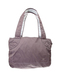

In [ ]:
# 🖼️ Carregar e exibir uma imagem aleatória para teste
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [ ]:
# 📝 Carrega os metadados do dataset de moda
# Alguns arquivos podem ter problemas de leitura, então usamos 'on_bad_lines=skip'
styles = pd.read_csv('/content/styles.csv', on_bad_lines='skip', engine='python')
styles['id'] = styles['id'].astype('str')  # Converte IDs para string
root_path = '/content'

# Salva o arquivo tratado no diretório raiz
styles.to_csv(root_path + '/styles.csv', index=False)


In [ ]:
# 🔎 Função que recebe um nome de arquivo e retorna seu índice correspondente na tabela 'styles'
def match_id(fname):
    return styles.index[styles.id == fname].values[0]


## **📌 Etapa 10: Carregar ou Criar o Indexador Annoy**

In [ ]:
# 🔄 Percorre todos os arquivos vetorizados e adiciona ao indexador Annoy
for findex, fname in tqdm(enumerate(allfiles)):
    file_vector = np.loadtxt(fname)  # Carrega o vetor da imagem
    file_name = os.path.basename(fname).split('.')[0]  # Obtém apenas o nome do arquivo
    file_index_to_file_name[findex] = file_name
    file_index_to_file_vector[findex] = file_vector

    try:
        file_index_to_product_id[findex] = match_id(file_name)  # Associa o ID da imagem com os metadados
    except IndexError:
        pass

    t.add_item(findex, file_vector)  # Adiciona ao indexador Annoy


Carregando vetores e indexador salvos...
Vetores carregados com sucesso!


In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

In [ ]:
# 🔄 Constrói o indexador Annoy com os vetores extraídos
t.build(trees)

# 💾 Salva o indexador localmente
t.save('t.ann')


In [ ]:
# 📂 Define o caminho base para armazenar os arquivos no Google Drive
file_path = '/content/drive/MyDrive/ImgSim/'

In [ ]:
# 💾 Salva o indexador Annoy e os mapeamentos no Google Drive para reutilização
t.save(file_path + 'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path + "file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path + "file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path + "file_index_to_product_id.p", "wb"))


## **📌 Etapa 11: Teste Local da Recomendação**
---
Agora que o indexador foi criado, testaremos a recomendação carregando uma imagem aleatória e encontrando as mais semelhantes.

In [ ]:
# 📸 Importação de bibliotecas para exibição de imagens
from PIL import Image
import matplotlib.image as mpimg

In [ ]:
# 🔎 Testamos a recomendação com uma imagem externa do Amazon
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

# 🔄 Baixa a imagem do link e a armazena localmente
!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'

# 🔎 Definir quantas recomendações queremos obter
topK = 4

# 🔄 Extraímos o vetor da imagem usando nosso modelo treinado
test_vec = np.squeeze(module(load_img(test_img)))

# 📏 Redimensiona a imagem para exibição
basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), resample=Image.Resampling.LANCZOS)
img

In [ ]:
# 🔄 Cria um dicionário para mapear os nomes dos arquivos para seus caminhos reais
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
    path_dict[path.name] = path

# 🔎 Encontra as imagens mais similares usando o indexador Annoy
nns = t.get_nns_by_vector(test_vec, n=topK)

# 📸 Exibe as imagens mais similares
plt.figure(figsize=(20, 10))
for i in range(topK):
    x = file_index_to_file_name[nns[i]]
    x = path_dict[x + '.jpg']
    y = file_index_to_product_id[nns[i]]
    title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
    plt.subplot(1, topK, i + 1)
    plt.title(title)
    plt.imshow(mpimg.imread(x))
    plt.axis('off')
plt.tight_layout()

## **📌 Etapa 12: Construindo APIs**

Nesta etapa, criamos duas APIs para permitir busca de produtos por similaridade de imagem:

*   **Streamlit API** → Interface visual para upload e recomendação de imagens.

*   **Flask API** → API REST para envio de imagens e obtenção de recomendações via código.

### **📌 Configurações Iniciais**

In [ ]:
# 📂 Importação de bibliotecas auxiliares para gerenciamento do sistema
import os
import time


In [ ]:
# 📂 Define o diretório raiz do projeto (onde estão os arquivos salvos no Google Drive)
root_path = '/content/drive/MyDrive/ImgSim'


## **📌 Criando a Estrutura de Encoders e Indexadores**

Criamos um arquivo utils.py que carrega:


*   **O modelo treinado** (bit_feature_extractor.keras) para extrair vetores das imagens.

*   **O indexador Annoy** (indexer.ann) para buscar imagens mais semelhantes.




In [ ]:
%%writefile utils.py
### ----utils.py---- ###

import os
import tensorflow as tf
from annoy import AnnoyIndex

root_path = '/content/drive/MyDrive/ImgSim'

class Encoder:
  # 🔄 Carrega o modelo de extração de características
  encoder = tf.keras.models.load_model(os.path.join(root_path, 'bit_feature_extractor.keras'))

class Indexer:
  # 🔄 Configura o indexador Annoy
  dims = 256
  topK = 6
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(root_path, 'indexer.ann'))

# Criamos objetos globais para acessar nas APIs
encoder = Encoder()
indexer = Indexer()


## **📌 Criando a API com Streamlit**

A **API em Streamlit** cria uma interface para que o usuário **envie uma imagem**, que será analisada pelo modelo e **comparada com o banco de imagens**, retornando **os produtos mais semelhantes**.

In [ ]:
%%writefile app.py
### ----app.py---- ###

import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import pickle
from pathlib import Path
import time
from utils import encoder, indexer  # 🔄 Importamos os módulos utilitários

root_path = '/content/drive/MyDrive/ImgSim'

# 🔄 Carrega o encoder e o indexador já treinados
start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# 📂 Carrega os metadados dos produtos
meta_data = pd.read_csv(os.path.join(root_path, 'styles.csv'))

# 📂 Carrega os dicionários de indexação
file_index_to_file_name = pickle.load(open(os.path.join(root_path, 'file_index_to_file_name.p'), 'rb'))
file_index_to_file_vector = pickle.load(open(os.path.join(root_path, 'file_index_to_file_vector.p'), 'rb'))
file_index_to_product_id = pickle.load(open(os.path.join(root_path, 'file_index_to_product_id.p'), 'rb'))

# 🔎 Mapeia as imagens para seus caminhos reais
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

# 🖼️ Função para carregar e preprocessar imagens
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

# 🎨 Configuração da Interface
st.title("🔍 Image Similarity App")
uploaded_file = st.file_uploader("📤 Escolha uma imagem...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    image.save(query_path)
    st.image(image, caption='📸 Imagem Enviada', use_column_width=True)
    st.write("🔍 Buscando imagens similares...")

    # 🔎 Extrai características da imagem enviada
    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    # 🔎 Busca as imagens mais similares no indexador
    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = []
    img_captions = []

    # 🔄 Recupera e exibe as imagens similares
    start_time = time.time()
    for i in nns:
      img_path = str(path_dict[file_index_to_file_name[i] + '.jpg'])
      img_file = Image.open(img_path)
      img_files.append(img_file)
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions.append(img_caption)

    print("---Output--- %s seconds ---" % (time.time() - start_time))

    st.image(img_files, caption=img_captions, width=200)


## **📌 Iniciando o Streamlit com ngrok**

In [ ]:
! pip install -q pyngrok
! ngrok config add-authtoken YOUR_NGROK_TOKEN
! cp /content/styles.csv /content/drive/MyDrive/ImgSim/

! pip install -q streamlit
! pip install -q colab-everything

from pyngrok import ngrok
ngrok_tunnel = ngrok.connect(8501)
print(f"Public URL: {ngrok_tunnel.public_url}")

!streamlit run app.py &> /dev/null &


## **📌 Criando a API REST com Flask**

Agora, criamos uma **API RESTful com Flask**, permitindo que **qualquer sistema externo** envie uma imagem via requisição **POST** e receba as recomendações.

In [ ]:
%%writefile flask_app.py
### ----flask_app.py---- ###

import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import os
import tensorflow as tf
import pickle
from pathlib import Path
import time
from utils import encoder, indexer
import io
import base64

from flask import Flask, request, jsonify

_PPATH = '/content/drive/MyDrive/ImgSim/'

# 🔄 Carregar modelo e indexador
start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# 📂 Carregar metadados e indexadores salvos
meta_data = pd.read_csv(_PPATH+'styles.csv')

file_index_to_file_name = pickle.load(open(_PPATH+'file_index_to_file_name.p', 'rb'))
file_index_to_file_vector = pickle.load(open(_PPATH+'file_index_to_file_vector.p', 'rb'))
file_index_to_product_id = pickle.load(open(_PPATH+'file_index_to_product_id.p', 'rb'))

# 🔎 Mapeia imagens para seus caminhos
path_dict = {path.name: path for path in Path('/content/Fashion_data/categories').rglob('*.jpg')}

# 🚀 Função para processar imagens
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

app = Flask(__name__)

@app.route("/fashion", methods=["POST"])
def home():
    file = request.files['image']
    img = Image.open(file.stream)
    img.save("/content/user_query.jpg")

    test_vec = np.squeeze(encoder(load_img("/content/user_query.jpg")))
    nns = t.get_nns_by_vector(test_vec, n=6)

    img_files = {}
    for count, i in enumerate(nns):
      img_path = str(path_dict[file_index_to_file_name[i] + '.jpg'])
      img_file = Image.open(img_path)
      img_byte_arr = io.BytesIO()
      img_file.save(img_byte_arr, format='PNG')
      img_files[count] = base64.encodebytes(img_byte_arr.getvalue()).decode('ascii')

    return jsonify(img_files)

app.run(debug=True)